In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
from scipy.io import wavfile
import scipy.signal
import torch

from playback import make_playback_animation

In [2]:
def load_lpcnet_features(feature_file, version=2):
    if version == 2 or version == 3:
        layout = {
            'cepstrum': [0,18],
            'periods': [18, 19],
            'pitch_corr': [19, 20],
            'lpc': [20, 36]
            }
        frame_length = 36

    elif version == 1:
        layout = {
            'cepstrum': [0,18],
            'periods': [36, 37],
            'pitch_corr': [37, 38],
            'lpc': [39, 55],
            }
        frame_length = 55
    else:
        raise ValueError(f'unknown feature version: {version}')


    raw_features = torch.from_numpy(np.fromfile(feature_file, dtype='float32'))
    raw_features = raw_features.reshape((-1, frame_length))

    features = torch.cat(
        [
            raw_features[:, layout['cepstrum'][0]   : layout['cepstrum'][1]],
            raw_features[:, layout['pitch_corr'][0] : layout['pitch_corr'][1]]
        ],
        dim=1
    )

    lpcs = raw_features[:, layout['lpc'][0]   : layout['lpc'][1]]
    if version < 3:
        periods = (0.1 + 50 * raw_features[:, layout['periods'][0] : layout['periods'][1]] + 100).long()
    else:
        periods = torch.round(torch.clip(256./2**(raw_features[:, layout['periods'][0] : layout['periods'][1]] + 1.5), 32, 256)).long()

    return {'features' : features, 'periods' : periods, 'lpcs' : lpcs}



In [3]:
def run_lpc(signal, lpcs, frame_length=160):
    num_frames, lpc_order = lpcs.shape

    prediction = np.concatenate(
        [- np.convolve(signal[i * frame_length : (i + 1) * frame_length + lpc_order - 1], lpcs[i], mode='valid') for i in range(num_frames)]
    )
    error = signal[lpc_order :] - prediction

    return prediction, error

In [4]:
lpcnet_features = load_lpcnet_features('lp/features.f32')

features = lpcnet_features['features'].numpy()
periods = lpcnet_features['periods'].squeeze(-1).numpy()
lpcs = lpcnet_features['lpcs'].numpy()

x = np.fromfile('data/a3_short.pcm', dtype=np.int16).astype(np.float32) / 2**15
x = np.concatenate((np.zeros(80), x, np.zeros(320)))
x_preemph = x.copy()
x_preemph[1:] -= 0.85 * x_preemph[:-1]

num_frames = features.shape[0]
x = x[:160 * num_frames]
x_preemph = x_preemph[:160 * num_frames]

In [5]:
# short-term prediction
pred, error = run_lpc(np.concatenate((np.zeros(16), x_preemph)), lpcs)

In [6]:
# long-term prediction
offset = 256
padded_error = np.concatenate((np.zeros(offset), error))
ltp_error = padded_error.copy()
for i, p in enumerate(list(periods)):
    t0 = i * 160 + offset
    t1 = t0 + 160
    
    past = padded_error[t0 - p : t1 - p]
    current = padded_error[t0 : t1]
    
    gain = np.dot(past, current) / (np.dot(past, past) + 1e-6)
    ltp_error[t0 : t1] -= gain * past
    
    
ltp_error = ltp_error[offset:]


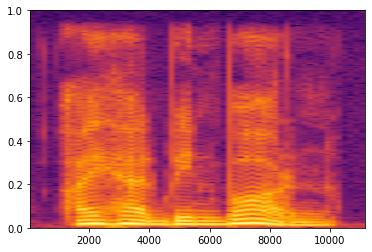

In [7]:
spec_x, freqs, t, im = plt.specgram(x, NFFT=512, cmap='inferno')

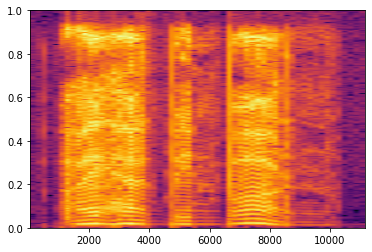

In [8]:
spec_stp_error, freqs, t, im = plt.specgram(error, NFFT=512, cmap='inferno')

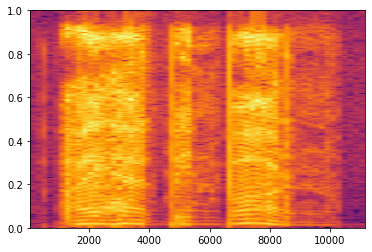

In [9]:
spec_ltp_error, freqs, t, im = plt.specgram(ltp_error, NFFT=512, cmap='inferno')

In [7]:
x_in = (x * (2 ** 15)).astype(np.int16)
x_stp = (error * (2 ** 15)).astype(np.int16)
x_ltp = (ltp_error * (2 ** 15)).astype(np.int16)

In [8]:
wavfile.write('lp/x_in.wav', 16000, x_in)
wavfile.write('lp/x_stp.wav', 16000, x_stp)
wavfile.write('lp/x_ltp.wav', 16000, x_ltp)

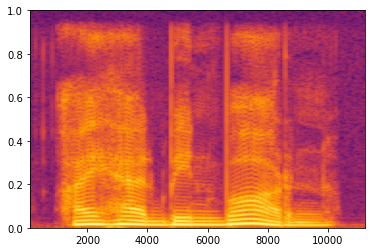

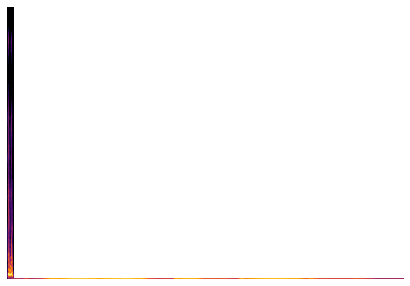

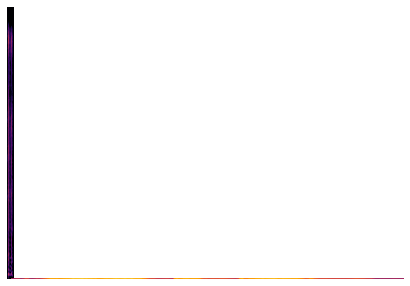

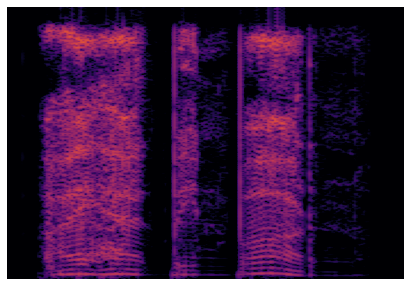

In [9]:
for y, name in [(x_in, 'x_in'), (x_stp, 'x_stp'), (x_ltp, 'x_ltp')]:
    spec, freqs, t, im = plt.specgram(y, NFFT=512, cmap='inferno', noverlap=256 + 128, pad_to=4096)
    spec = 10*np.log10(spec)
    
    make_playback_animation(f'lp/{name}_spec.mp4', spec, len(y)/16)